# Imports

In [1]:
# Import of basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Sklearn imports
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split, cross_validate, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, matthews_corrcoef, make_scorer, confusion_matrix

In [2]:
# Import dataset
path ="https://github.com/KingKai69/VisualAnalytics/raw/main/Automobile_data.csv"
df = pd.read_csv(path)
df.rename(columns={'symboling': 'risk-score'}, inplace=True)
df.head()

,risk-score,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


In [ ]:
df.describe()

,risk-score,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,10.142537,25.219512,30.751220
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,3.972040,6.542142,6.886443
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,8.600000,19.000000,25.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,9.000000,24.000000,30.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,9.400000,30.000000,34.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000


# Data Preprocessing

## Interpolation

In [ ]:
# Check if columns contain NaN values.
df.isna().any()

risk-score           False
normalized-losses    False
make                 False
fuel-type            False
aspiration           False
num-of-doors         False
body-style           False
drive-wheels         False
engine-location      False
wheel-base           False
length               False
width                False
height               False
curb-weight          False
engine-type          False
num-of-cylinders     False
engine-size          False
fuel-system          False
bore                 False
stroke               False
compression-ratio    False
horsepower           False
peak-rpm             False
city-mpg             False
highway-mpg          False
price                False
dtype: bool

In [3]:
# Interpolation of '?' that are created during csv import. Replace '?' values with NaN values an in turn replace NaN values with the mode of the respective column. 
df.replace('?', float('nan'), inplace=True)
df_imp = df.fillna(df.mode().iloc[0])
df_imp.isna().any()

risk-score           False
normalized-losses    False
make                 False
fuel-type            False
aspiration           False
num-of-doors         False
body-style           False
drive-wheels         False
engine-location      False
wheel-base           False
length               False
width                False
height               False
curb-weight          False
engine-type          False
num-of-cylinders     False
engine-size          False
fuel-system          False
bore                 False
stroke               False
compression-ratio    False
horsepower           False
peak-rpm             False
city-mpg             False
highway-mpg          False
price                False
dtype: bool

## Label Encoding

In [4]:
# Init new LabelEncoder object
le = LabelEncoder()

# Init dataframe for encoded data
df_enc = df_imp.copy()

# Encoding of columns with categorical data
columns_to_encode = ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location','engine-type','num-of-cylinders','fuel-system'] 
encoding_mapping = {}
for column in columns_to_encode:
    df_enc[column] = le.fit_transform(df_enc[column])
    encoding_mapping[column] = dict(zip(le.classes_, le.transform(le.classes_)))

#df_enc.head()

In [ ]:
# Print encoding mapping
for column, mapping in encoding_mapping.items():
    print(f"Spalte: {column}")
    for category, encoded_value in mapping.items():
        print(f"{category} : {encoded_value}")
    print()

Spalte: make
alfa-romero : 0
audi : 1
bmw : 2
chevrolet : 3
dodge : 4
honda : 5
isuzu : 6
jaguar : 7
mazda : 8
mercedes-benz : 9
mercury : 10
mitsubishi : 11
nissan : 12
peugot : 13
plymouth : 14
porsche : 15
renault : 16
saab : 17
subaru : 18
toyota : 19
volkswagen : 20
volvo : 21

Spalte: fuel-type
diesel : 0
gas : 1

Spalte: aspiration
std : 0
turbo : 1

Spalte: num-of-doors
four : 0
two : 1

Spalte: body-style
convertible : 0
hardtop : 1
hatchback : 2
sedan : 3
wagon : 4

Spalte: drive-wheels
4wd : 0
fwd : 1
rwd : 2

Spalte: engine-location
front : 0
rear : 1

Spalte: engine-type
dohc : 0
dohcv : 1
l : 2
ohc : 3
ohcf : 4
ohcv : 5
rotor : 6

Spalte: num-of-cylinders
eight : 0
five : 1
four : 2
six : 3
three : 4
twelve : 5
two : 6

Spalte: fuel-system
1bbl : 0
2bbl : 1
4bbl : 2
idi : 3
mfi : 4
mpfi : 5
spdi : 6
spfi : 7



In [5]:
# Changes dtypes of respective column from object to int64 respective float 64. 
for col in df_enc.columns:
    if df_enc[col].dtype == 'object':
        try:
            df_enc[col] = df_enc[col].astype('int64')
        except ValueError:
            try:
                df_enc[col] = df_enc[col].astype('float64')
            except ValueError:
                pass  

print(df_enc.dtypes)

risk-score             int64
normalized-losses      int64
make                   int64
fuel-type              int64
aspiration             int64
num-of-doors           int64
body-style             int64
drive-wheels           int64
engine-location        int64
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type            int64
num-of-cylinders       int64
engine-size            int64
fuel-system            int64
bore                 float64
stroke               float64
compression-ratio    float64
horsepower             int64
peak-rpm               int64
city-mpg               int64
highway-mpg            int64
price                  int64
dtype: object


## Scaling

In [6]:
# Create df without target
df_features = df_enc.drop(['risk-score'], axis=1)

# Init new SandardScaler object
scaler = StandardScaler()

# Fit scaler
scaled_data = scaler.fit_transform(df_features)
df_sc = pd.DataFrame(scaled_data, columns=df_features.columns)

# Append target to scaled data
df_sc['risk-score'] = df_enc['risk-score']

## Correlation analysis

In [7]:
# Create list of all possible features (25)
features = [
    'normalized-losses',
    'make',
    'fuel-type',
    'aspiration',
    'num-of-doors',
    'body-style',
    'drive-wheels',
    'engine-location',
    'wheel-base',
    'length',
    'width',
    'height',
    'curb-weight',
    'engine-type',
    'num-of-cylinders',
    'engine-size',
    'fuel-system',
    'bore',
    'stroke',
    'compression-ratio',
    'horsepower',
    'peak-rpm',
    'city-mpg',
    'highway-mpg',
    'price',
]

<Axes: >

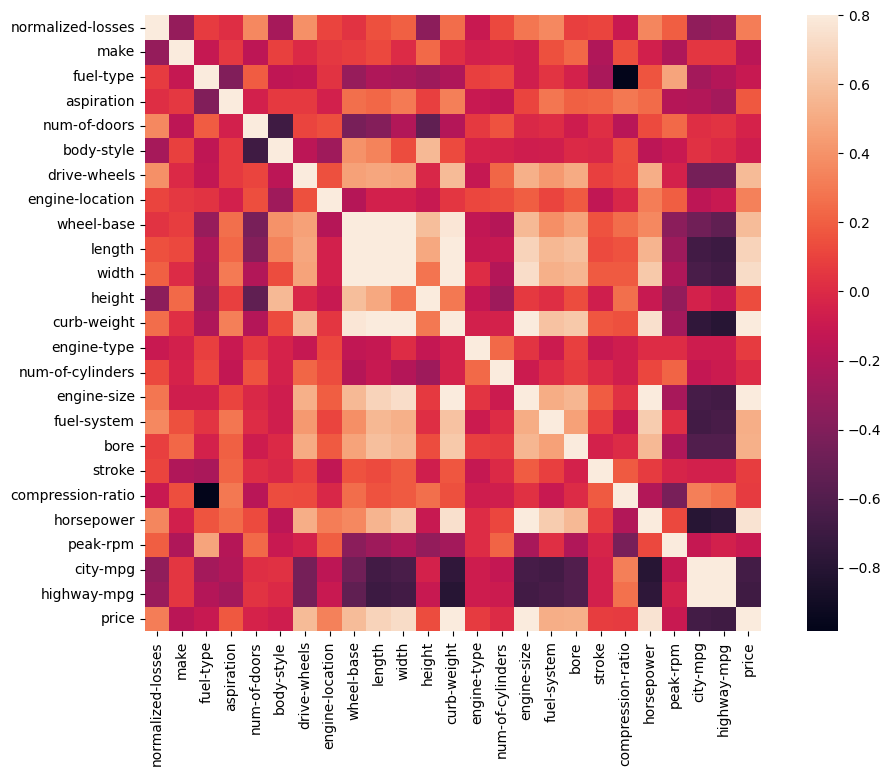

In [ ]:
# Create correlation matrix
Val = df_enc[features]
corrmat = Val.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corrmat, vmax=.8, square=True)

In [ ]:
# Create df with high correlated feature pairs
corrmat_masked = corrmat.mask(abs(corrmat) >= 1)

# Filter correlation above/below 0.7/-0.7
high_corr = corrmat_masked[(corrmat_masked > 0.7) | (corrmat_masked < -0.7)].stack().reset_index()
high_corr.columns = ['Feature_A', 'Feature_B', 'Correlation']

# Remove duplicates
high_corr = high_corr[high_corr['Feature_A'] < high_corr['Feature_B']]

high_corr.head(n=120)

,Feature_A,Feature_B,Correlation
2,wheel-base,width,0.795144
4,length,wheel-base,0.874587
5,length,width,0.841118
13,curb-weight,wheel-base,0.776386
14,curb-weight,length,0.877728
15,curb-weight,width,0.867032
16,curb-weight,engine-size,0.850594
17,curb-weight,horsepower,0.748539
19,curb-weight,highway-mpg,-0.797465
20,curb-weight,price,0.820807


# Modelling

In [8]:
# Create 3 classification label and check for imbalance
df_enc_3 = df_enc.copy()
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(3, 'high-risk')
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(2, 'high-risk')
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(1, 'medium-risk')
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(0, 'medium-risk')
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(-1, 'low-risk')
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(-2, 'low-risk')
pd.value_counts(df_enc_3['risk-score'])

medium-risk    121
high-risk       59
low-risk        25
Name: risk-score, dtype: int64

In [9]:
# Create list of features
features_nonCor = [
    'normalized-losses',
    'make',
    'fuel-type',
    'aspiration',
    'num-of-doors',
    'body-style',
    'drive-wheels',
    'engine-location',
    #'wheel-base',
    #'length',
    #'width',
    'height',
    'curb-weight',
    'engine-type',
    'num-of-cylinders',
    #'engine-size',
    'fuel-system',
    'bore',
    'stroke',
    #'compression-ratio',
    'horsepower',
    'peak-rpm',
    'city-mpg',
    #'highway-mpg',
    #'price',
]

In [10]:
# Fixing the SEED
SEED = 27

In [11]:
# Define X and Y data, both for scaled and non scaled data
x_data = df_enc_3[features_nonCor]
y_data = df_enc_3['risk-score']

x_data_s = df_sc[features_nonCor]
y_data_s = df_sc['risk-score']

In [12]:
# Train Test Split for non scaled data
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=SEED, stratify=y_data)

# Train Test for scaled data
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(x_data_s, y_data_s, test_size=0.25, random_state=SEED, stratify=y_data_s)

In [ ]:
# Check distribution of classification labels in test set
labels = ['high-risk', 'medium-risk', 'low-risk']

# Init counter
counter = {label: 0 for label in labels}

# Zähle das Vorkommen der Begriffe in der Liste
for element in y_test:
    if element in counter:
        counter[element] += 1

# Ergebnis ausgeben
for begriff, anzahl in counter.items():
    anteil = anzahl / len(y_test)
    print(f"'{begriff}' occurs {anzahl} times. Share of total: {anteil:.2%}")

# Same share than in origin data

'high-risk' occurs 15 times. Share of total: 28.85%
'medium-risk' occurs 31 times. Share of total: 59.62%
'low-risk' occurs 6 times. Share of total: 11.54%


In [13]:
# Init KFold for cross validation
kf_cv = KFold(n_splits = 5, shuffle = True, random_state=SEED)

# Spot Checking

In [ ]:
# Definitions of metric
scorings = {
    'f1_score': make_scorer(f1_score, average='weighted', zero_division=1), 
    'mcc': make_scorer(matthews_corrcoef),
    }

In [ ]:
# Definition of models for spot checking
def get_models():
    models=[
       ('Decision Tree',DecisionTreeClassifier(random_state = SEED)),
       ('Random Forest',RandomForestClassifier(random_state = SEED)),
       ('Extremely Randomized Trees',ExtraTreesClassifier(random_state = SEED)),
       ('Ada Boost',AdaBoostClassifier(random_state = SEED)),
       ('Gradient Boosting',GradientBoostingClassifier(random_state = SEED)),
       ('Support Vector Machine', SVC()),   
       ('Naive Bayes', GaussianNB()),    
       ('KNN', KNeighborsClassifier()),    
       ('Support Vector Machine', SVC()),
       ('Multilayer Perceptron',MLPClassifier(max_iter = 1000, random_state = SEED)),
    ]
    return models

## Non scaled data

In [ ]:
# Get our set of different models for the spot checking
models = get_models()

# Empty list to print the results as a nice table
all_cv_scores = []

# We will iter through our list of models
# We will perform the full cross validate run using the current model
for name, clf in tqdm(models):
    
    # We want to improve the printing of our results
    # Therefore we add all the values into a dictionary which we will format for later printing using Pandas 
    formatted_result = {}
    formatted_result['Classifier'] = name

    # Use the simple cross_validate wrapper greatly simplifies the spot checking. We will just compare the models using our 
    cv_score  = cross_validate(estimator = clf, X = X_train, y = y_train, cv = kf_cv, scoring = scorings)

    # cv scores contains the arrays with the score for the current scoring function
    # We will calculate the mean and std and add them to the formatted result dictionary
    for score_name, scores in cv_score.items():
        # Add the completely prepared string 
        formatted_result[f'{score_name}_mean'] = np.mean(scores)
        formatted_result[f'{score_name}_std'] = np.std(scores)
        
        #formatted_result[f'{score_name}'] = scores # We could also add the raw data to the dataframe. However this will make is less readable

    # We need to add the final rows of our results to an overall list.
    # This simplifies the creation of the dataframe
    all_cv_scores.append(formatted_result)

100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


In [ ]:
pd.DataFrame(all_cv_scores)

,Classifier,fit_time_mean,fit_time_std,score_time_mean,score_time_std,test_f1_score_mean,test_f1_score_std,test_mcc_mean,test_mcc_std
0,Decision Tree,0.006061,0.003004,0.005426,0.001830,0.789869,0.072955,0.642869,0.093273
1,Random Forest,0.158679,0.005571,0.014141,0.000689,0.870496,0.080793,0.761963,0.146558
2,Extremely Randomized Trees,0.123088,0.003904,0.016296,0.003885,0.865364,0.108655,0.767872,0.171990
3,Ada Boost,0.088514,0.003329,0.011951,0.000673,0.663277,0.098949,0.407303,0.172460
4,Gradient Boosting,0.325167,0.011504,0.005159,0.000423,0.839788,0.111970,0.718026,0.181241
5,Support Vector Machine,0.004561,0.001358,0.004802,0.000745,0.438752,0.095483,0.000000,0.000000
6,Naive Bayes,0.002602,0.000093,0.004095,0.000238,0.646885,0.055324,0.416781,0.054555
7,KNN,0.002492,0.000070,0.016053,0.019142,0.633144,0.104011,0.339174,0.195865
8,Support Vector Machine,0.003836,0.000400,0.004368,0.000245,0.438752,0.095483,0.000000,0.000000
9,Multilayer Perceptron,0.023304,0.004755,0.005788,0.000929,0.420512,0.091785,0.099544,0.074527


## Scaled data

In [ ]:
# Get our set of different models for the spot checking
models = get_models()

# Empty list to print the results as a nice table
all_cv_scores_s = []

# We will iter through our list of models
# We will perform the full cross validate run using the current model
for name, clf in tqdm(models):
    
    # We want to improve the printing of our results
    # Therefore we add all the values into a dictionary which we will format for later printing using Pandas 
    formatted_result = {}
    formatted_result['Classifier'] = name

    # Use the simple cross_validate wrapper greatly simplifies the spot checking. We will just compare the models using our 
    cv_score  = cross_validate(estimator = clf, X = x_data_s, y = y_data_s, cv = kf_cv, scoring = scorings)

    # cv scores contains the arrays with the score for the current scoring function
    # We will calculate the mean and std and add them to the formatted result dictionary
    for score_name, scores in cv_score.items():
        # Add the completely prepared string 
        formatted_result[f'{score_name}_mean'] = np.mean(scores)
        formatted_result[f'{score_name}_std'] = np.std(scores)
        
        #formatted_result[f'{score_name}'] = scores # We could also add the raw data to the dataframe. However this will make is less readable

    # We need to add the final rows of our results to an overall list.
    # This simplifies the creation of the dataframe
    all_cv_scores_s.append(formatted_result)

100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


In [ ]:
pd.DataFrame(all_cv_scores_s)

,Classifier,fit_time_mean,fit_time_std,score_time_mean,score_time_std,test_f1_score_mean,test_f1_score_std,test_mcc_mean,test_mcc_std
0,Decision Tree,0.003987,0.001345,0.004814,0.001176,0.730214,0.062094,0.648923,0.086798
1,Random Forest,0.258253,0.076474,0.023590,0.008292,0.761489,0.037946,0.693468,0.055041
2,Extremely Randomized Trees,0.313997,0.058094,0.044412,0.021020,0.785991,0.056933,0.724595,0.068262
3,Ada Boost,0.244041,0.145653,0.029639,0.020531,0.437957,0.072186,0.319087,0.062481
4,Gradient Boosting,0.848298,0.142141,0.006534,0.001173,0.765999,0.041642,0.696133,0.050764
5,Support Vector Machine,0.005118,0.000970,0.004927,0.000354,0.676969,0.067062,0.594367,0.072343
6,Naive Bayes,0.002712,0.000132,0.004235,0.000122,0.370759,0.077938,0.352419,0.064948
7,KNN,0.002503,0.000326,0.007158,0.000322,0.595001,0.045552,0.479897,0.065941
8,Support Vector Machine,0.004651,0.000207,0.004902,0.000546,0.676969,0.067062,0.594367,0.072343
9,Multilayer Perceptron,0.949166,0.065567,0.006301,0.000172,0.722104,0.065038,0.633204,0.073030


# Hyperparametertuning

## Randomized Search

In [ ]:
#Init best model for hyperparametertuning
model = RandomForestClassifier(class_weight='balanced', random_state = SEED)

# define parameter space
param_dist = {
              'n_estimators': np.arange(50, 501, 10),
              "criterion": ["gini", "entropy", 'log_loss'],
              "max_depth": np.arange(1, 26, 1),
              "min_samples_split": np.arange(1, 26, 1),
              "min_samples_leaf": np.arange(1, 26, 1),
              "max_features": ["sqrt", "log2", None], 
              "bootstrap": [True, False],
              }

# Init optimizer
hyperparam_optimizer = RandomizedSearchCV(estimator = model, # The estimator or pipeline we want to optimize
                                          param_distributions = param_dist, # Our parameter grid
                                          n_iter = 25, # Searches for 10 random combinations
                                          n_jobs = -1, # Use all available CPU cores
                                          scoring = "f1_weighted", # Name of the scorer used for 
                                          cv = kf_cv # The CrossValidation to use
                                          )

In [ ]:
# Fit the randomized search object
hyperparam_optimizer.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters found: ", hyperparam_optimizer.best_params_)
print("Best F1 score found: ", hyperparam_optimizer.best_score_)

# Evaluation 5 fold cross validation (seen data)

Durchschnittlicher F1-Score: 0.86
Standardabweichung des F1-Scores: 0.07


Text(70.72222222222221, 0.5, 'Actual')

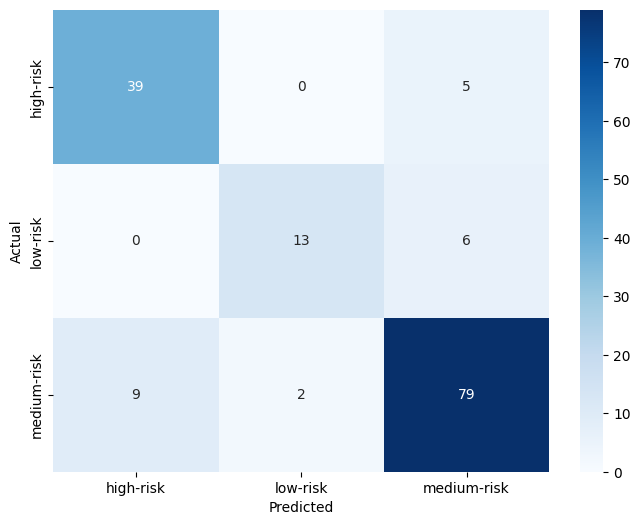

In [15]:
# Init new classifier with best setting of Hyperparameters
clf_final = RandomForestClassifier(n_estimators=301, criterion="gini", max_depth=12 , max_features='sqrt', min_samples_split=5, min_samples_leaf=1, bootstrap=False, class_weight='balanced', random_state = SEED)

scoring = {'f1_score': make_scorer(f1_score, average='weighted', zero_division=1)}

cv_final = cross_validate(estimator = clf_final, X = X_train, y = y_train, cv = kf_cv, scoring = scoring)

f1_scores_cv = cv_final['test_f1_score']

# Calculate mean F1_score
mean_f1_score_cv = np.mean(f1_scores_cv)
std_f1_score_cv = np.std(f1_scores_cv)

# Create confusion matrix
y_pred_cv = cross_val_predict(clf_final, X_train, y_train, cv=kf_cv)
cm_cv = confusion_matrix(y_train, y_pred_cv)

# Print results
print("Durchschnittlicher F1-Score: {:.2f}".format(mean_f1_score_cv))
print("Standardabweichung des F1-Scores: {:.2f}".format(std_f1_score_cv))


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cv, annot=True, cmap='Blues', fmt='d', xticklabels=['high-risk','low-risk','medium-risk'], yticklabels=['high-risk','low-risk','medium-risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Evaluation of test data (unseen data)

In [16]:
# Fit the model
clf_final.fit(X_train, y_train)

# Create predictions
y_pred_final = clf_final.predict(X_test)

# Calculate F1score
f1_final = f1_score(y_test, y_pred_final, average='weighted', zero_division=1)
print("F1-Score: {:.2f}".format(f1_final))

F1-Score: 0.90


Text(70.72222222222221, 0.5, 'Actual')

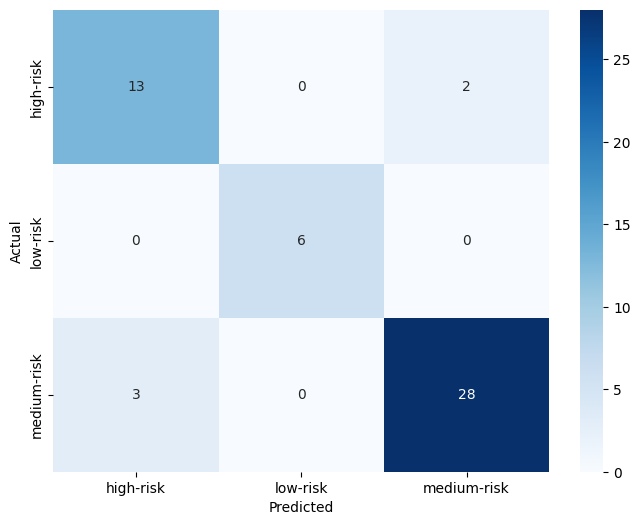

In [17]:
cm_final = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, cmap='Blues', fmt='d', xticklabels=clf_final.classes_, yticklabels=clf_final.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')

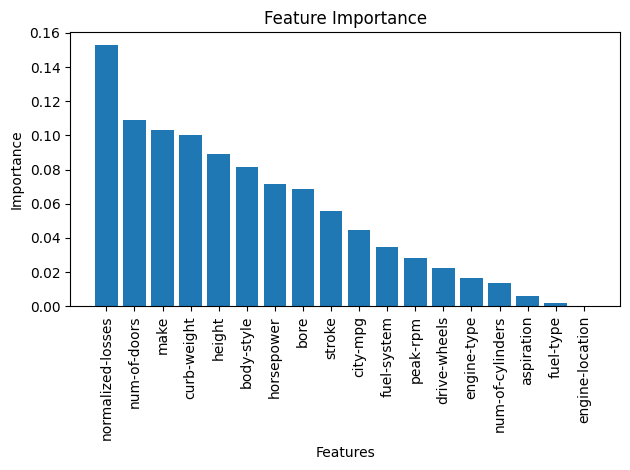

In [22]:
# Calculate feature importance 
importance = clf_final.feature_importances_

# Sort feature importance descending
sorted_indices = np.argsort(importance)[::-1]
sorted_importance = importance[sorted_indices]
feature_names = X_test.columns[sorted_indices]

fig, ax = plt.subplots()
ax.bar(range(X_test.shape[1]), sorted_importance)
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance')
ax.set_xticks(range(X_test.shape[1]))
ax.set_xticklabels(feature_names, rotation='vertical')
plt.tight_layout()
plt.show()

# Explainable AI

In [23]:
df_results = pd.DataFrame({'Test Labels': y_test, 'Predicted Labels': y_pred_final})
df_results.describe()

,Test Labels,Predicted Labels
count,52,52
unique,3,3
top,medium-risk,medium-risk
freq,31,30


In [ ]:
df_results.head(n=60)

,Test Labels,Predicted Labels
104,high-risk,high-risk
130,medium-risk,medium-risk
102,medium-risk,medium-risk
149,medium-risk,medium-risk
30,high-risk,high-risk
179,high-risk,high-risk
175,low-risk,low-risk
178,high-risk,high-risk
67,low-risk,low-risk
167,high-risk,high-risk


In [35]:
# Create df with false classification. In addition the df contains the feature values.
df_exp = pd.concat([X_test, df_results], axis=1)
df_exp_false = df_exp[df_exp['Test Labels'] != df_exp['Predicted Labels']]
df_exp_false.loc[:, 'iloc_xtest_df'] = [29, 31, 38, 45, 50]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
df_exp_corr = df_exp[df_exp['Test Labels'] == df_exp['Predicted Labels']]
df_exp_corr_hr = df_exp[(df_exp['Test Labels'] == 'high-risk') & (df_exp['Predicted Labels'] == 'high-risk')]
df_exp_corr_mr = df_exp[(df_exp['Test Labels'] == 'medium-risk') & (df_exp['Predicted Labels'] == 'medium-risk')]


In [ ]:
df_exp_corr_hr.describe()

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,height,curb-weight,engine-type,num-of-cylinders,fuel-system,bore,stroke,horsepower,peak-rpm,city-mpg
count,13.000000,13.000000,13.0,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,156.846154,13.000000,1.0,0.153846,0.923077,1.923077,1.538462,0.076923,52.269231,2606.000000,2.769231,2.538462,4.615385,3.378462,3.293077,126.923077,5334.615385,22.846154
std,28.398492,6.324555,0.0,0.375534,0.277350,0.759555,0.518875,0.277350,2.369031,368.389739,1.832750,1.198289,1.757767,0.234941,0.178810,40.046768,367.074365,8.345120
min,94.000000,1.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,49.400000,1713.000000,0.000000,1.000000,0.000000,2.910000,2.900000,58.000000,4800.000000,17.000000
25%,150.000000,8.000000,1.0,0.000000,1.000000,2.000000,1.000000,0.000000,50.800000,2385.000000,3.000000,2.000000,5.000000,3.190000,3.230000,101.000000,5200.000000,19.000000
50%,153.000000,15.000000,1.0,0.000000,1.000000,2.000000,2.000000,0.000000,52.000000,2658.000000,3.000000,2.000000,5.000000,3.430000,3.350000,116.000000,5250.000000,20.000000
75%,161.000000,19.000000,1.0,0.000000,1.000000,2.000000,2.000000,0.000000,53.100000,2808.000000,3.000000,3.000000,5.000000,3.540000,3.400000,160.000000,5500.000000,24.000000
max,197.000000,20.000000,1.0,1.000000,1.000000,3.000000,2.000000,1.000000,56.100000,3071.000000,6.000000,6.000000,7.000000,3.740000,3.500000,207.000000,6000.000000,49.000000


In [ ]:
df_exp_corr_mr.describe()

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,height,curb-weight,engine-type,num-of-cylinders,fuel-system,bore,stroke,horsepower,peak-rpm,city-mpg
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.0,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,126.928571,10.428571,0.928571,0.142857,0.285714,3.071429,1.142857,0.0,54.264286,2523.535714,2.857143,2.107143,2.785714,3.293571,3.279643,94.750000,5153.571429,26.071429
std,31.903708,5.871643,0.262265,0.356348,0.460044,0.662687,0.590937,0.0,2.132329,567.518607,1.007905,0.416270,2.043185,0.258990,0.333439,31.632877,572.507249,5.727960
min,81.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.0,50.600000,1909.000000,0.000000,1.000000,0.000000,2.910000,2.640000,62.000000,4150.000000,15.000000
25%,102.000000,5.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.0,52.600000,2030.250000,3.000000,2.000000,1.000000,3.050000,3.110000,69.750000,4800.000000,23.000000
50%,123.000000,12.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.0,54.100000,2362.500000,3.000000,2.000000,2.000000,3.275000,3.290000,89.000000,5200.000000,26.500000
75%,161.000000,14.500000,1.000000,0.000000,1.000000,3.250000,1.250000,0.0,55.325000,2984.250000,3.000000,2.000000,5.000000,3.500000,3.410000,104.000000,5500.000000,30.000000
max,188.000000,19.000000,1.000000,1.000000,1.000000,4.000000,2.000000,0.0,59.100000,4066.000000,5.000000,3.000000,5.000000,3.700000,4.170000,182.000000,6600.000000,38.000000


In [ ]:
# Count values for num-of-doors
counts_mr = df_exp_corr_mr['num-of-doors'].value_counts()
counts_hr = df_exp_corr_hr['num-of-doors'].value_counts()

# Results
print('Result_mr')
print(counts_mr)
print('Result_hr')
print(counts_hr)

Result_mr
0    20
1     8
Name: num-of-doors, dtype: int64
Result_hr
1    12
0     1
Name: num-of-doors, dtype: int64


In [ ]:
# Count values for body-style
counts_mr = df_exp_corr_mr['body-style'].value_counts()
counts_hr = df_exp_corr_hr['body-style'].value_counts()

# Results
print('Result_mr')
print(counts_mr)
print('Result_hr')
print(counts_hr)

Result_mr
3    16
4     7
2     5
Name: body-style, dtype: int64
Result_hr
2    9
3    2
1    1
0    1
Name: body-style, dtype: int64


In [ ]:
df_exp_false.head()

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,height,curb-weight,...,num-of-cylinders,fuel-system,bore,stroke,horsepower,peak-rpm,city-mpg,Test Labels,Predicted Labels,iloc_xtest_df
2,161,0,1,0,1,2,2,0,52.4,2823,...,3,5,2.68,3.47,154,5000,19,medium-risk,high-risk,29
69,93,9,0,1,1,1,2,0,54.9,3495,...,1,3,3.58,3.64,123,4350,22,medium-risk,high-risk,31
3,164,1,1,0,0,3,1,0,54.3,2337,...,2,5,3.19,3.40,102,5500,24,high-risk,medium-risk,38
98,168,12,1,0,1,1,1,0,53.3,2008,...,2,1,3.15,3.29,69,5200,31,high-risk,medium-risk,45
75,161,10,1,1,1,2,2,0,54.8,2910,...,2,5,3.78,3.12,175,5000,19,medium-risk,high-risk,50


# SHAP

In [26]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.0 MB/s eta 0:00:00


In [27]:
import shap

## Compute Shap Values

In [28]:
explainer_tree = shap.TreeExplainer(clf_final) #Conditional Expectation --> unrealistische Dateninstanzen
shap_values_tree = explainer_tree.shap_values(X_test) ##Nochmal schauen welche Daten (Test, Train, alle) wirklich relevant sind
#shap_single = explainer_tree.shap_values(X_test.iloc[0,:])

#SHAP Resampling

In [ ]:
df_exp_false.head()

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,height,curb-weight,...,num-of-cylinders,fuel-system,bore,stroke,horsepower,peak-rpm,city-mpg,Test Labels,Predicted Labels,iloc_xtest
2,161,0,1,0,1,2,2,0,52.4,2823,...,3,5,2.68,3.47,154,5000,19,medium-risk,high-risk,29
69,93,9,0,1,1,1,2,0,54.9,3495,...,1,3,3.58,3.64,123,4350,22,medium-risk,high-risk,31
3,164,1,1,0,0,3,1,0,54.3,2337,...,2,5,3.19,3.40,102,5500,24,high-risk,medium-risk,38
98,168,12,1,0,1,1,1,0,53.3,2008,...,2,1,3.15,3.29,69,5200,31,high-risk,medium-risk,45
75,161,10,1,1,1,2,2,0,54.8,2910,...,2,5,3.78,3.12,175,5000,19,medium-risk,high-risk,50


In [ ]:
print(clf_final.classes_)

['high-risk' 'low-risk' 'medium-risk']


In [ ]:
# Class0 = high-risk
# Class1 = low-risk
# Class2 = medium-risk

## Force Plots

In [ ]:
# Explain Single prediction from test set
iloc = 50
shap.initjs()


shap.force_plot(explainer_tree.expected_value[0], shap_values_tree[0][iloc], X_test.iloc[iloc,:])


#############################
##### Class 0 High risk #####
#############################

In [ ]:
shap.initjs()
shap.force_plot(explainer_tree.expected_value[1], shap_values_tree[1][iloc], X_test.iloc[iloc,:])

#############################
##### Class 1 low risk ######
#############################

In [ ]:
shap.initjs()
shap.force_plot(explainer_tree.expected_value[2], shap_values_tree[2][iloc], X_test.iloc[iloc,:])

###############################
##### Class 2 medium risk #####
###############################

- Three force plots one for each target class --> model predicts class with 
  highest score
- The bold value is the models score for this observation
- red representing features that pushed the model score higher
- blue representing features that pushed the score lower.
  - Ausgangspunkt Base Value ??
- Je größer der Pfeil desto größer der impact
- The base value (durchschnittlicher Vorhersagewert / expected value for each class): this is the value that would be predicted if we didn’t know any features for the current instance. The base value is the average of the model output over the training dataset (explainer.expected_value in the code). In this example base value = 0.5749


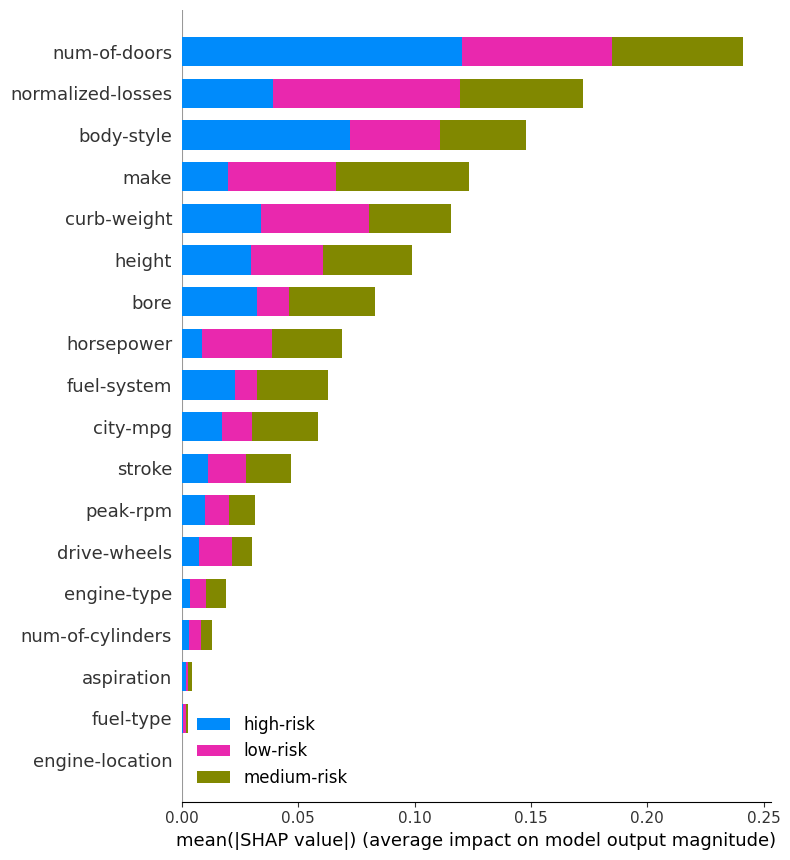

In [ ]:
shap.summary_plot(shap_values_tree, X_test, class_inds="original", class_names=clf_final.classes_)
#shap.summary_plot(shap_values_tree, X_test, class_inds="original")

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. You can see that the feature pkts_sent, being the least important feature, has low Shapley values. The color represents the value of the feature from low to high. Overlapping points are jittered in the y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


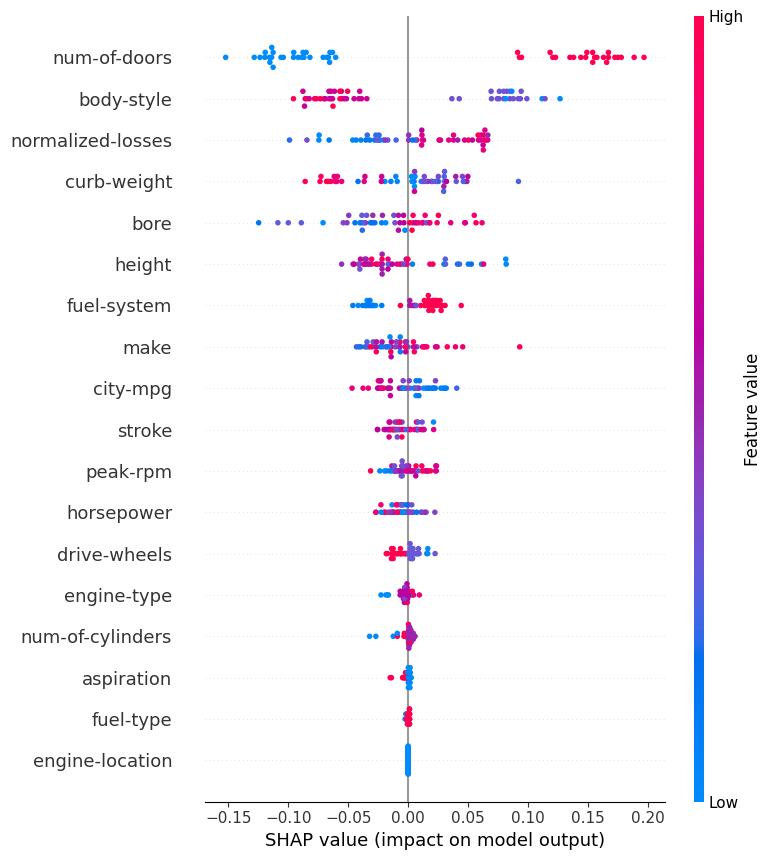

In [ ]:
# Summary Plot 'high-risk'
shap.summary_plot(shap_values_tree[0], X_test)

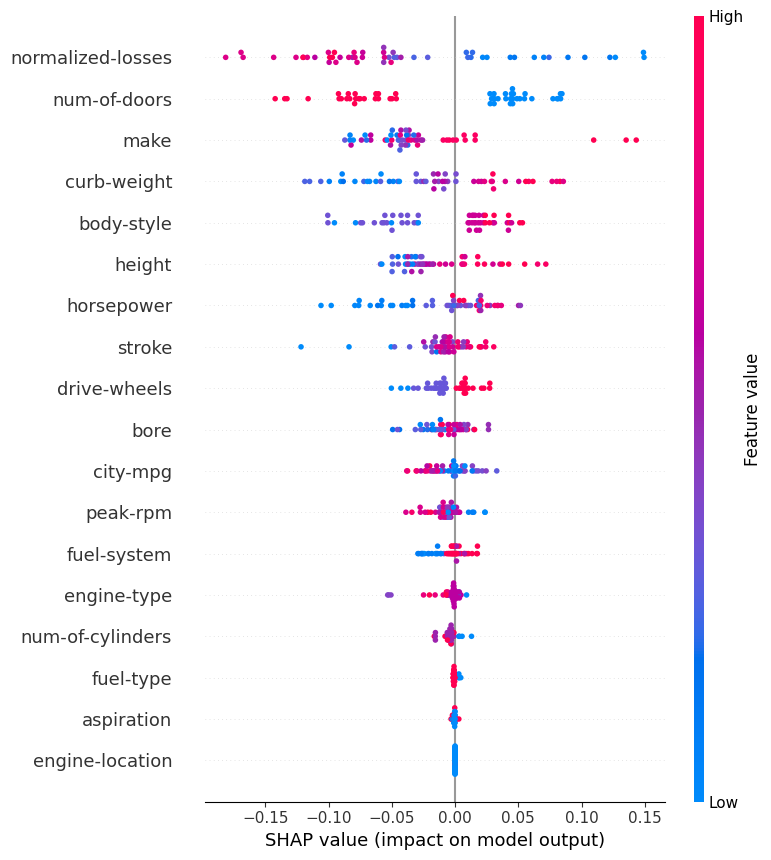

In [ ]:
# Summary plot low risk
shap.summary_plot(shap_values_tree[1], X_test)

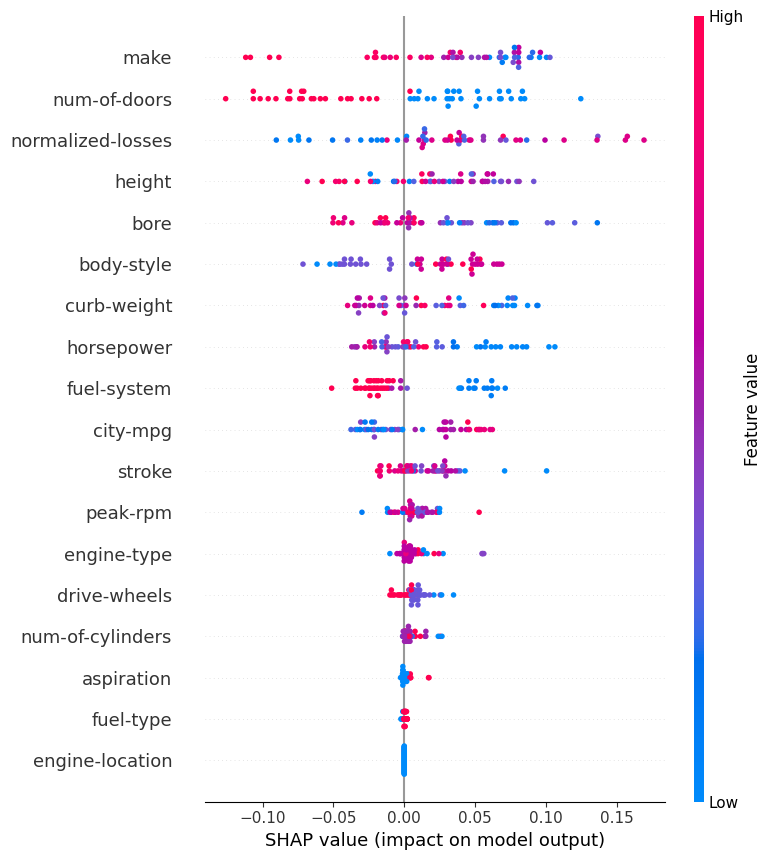

In [ ]:
# Summary plot 'medium-risk'
shap.summary_plot(shap_values_tree[2], X_test)

# Backlog

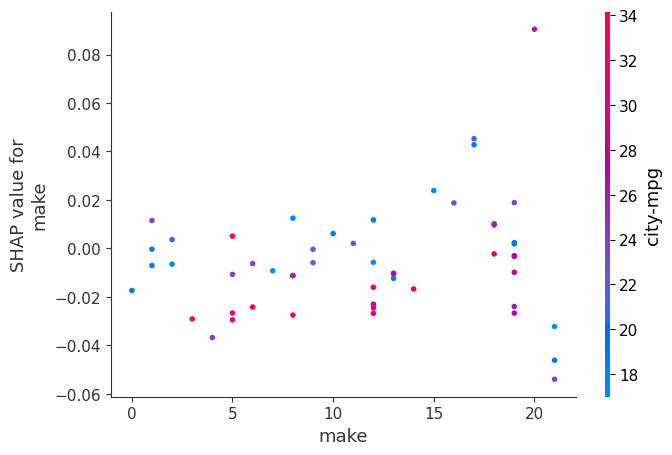

In [32]:
shap.dependence_plot('make', shap_values_tree[0], X_test.values, feature_names=X_test.columns)

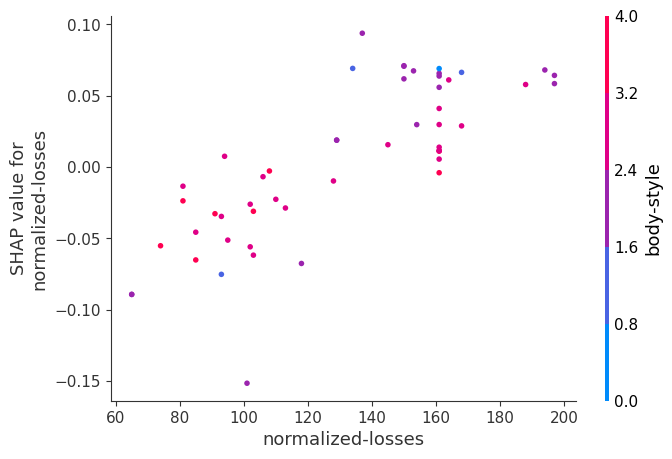

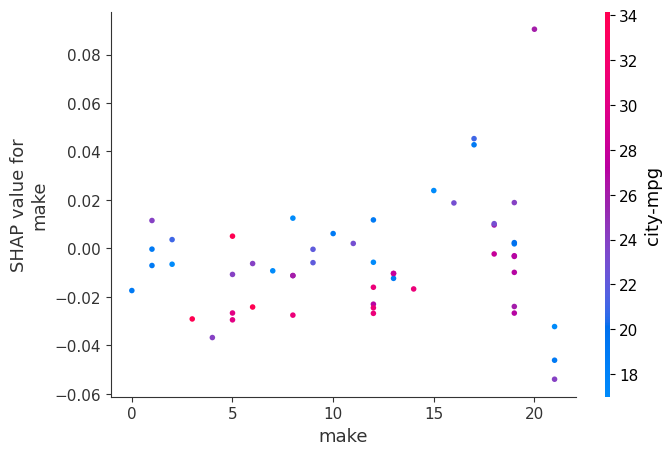

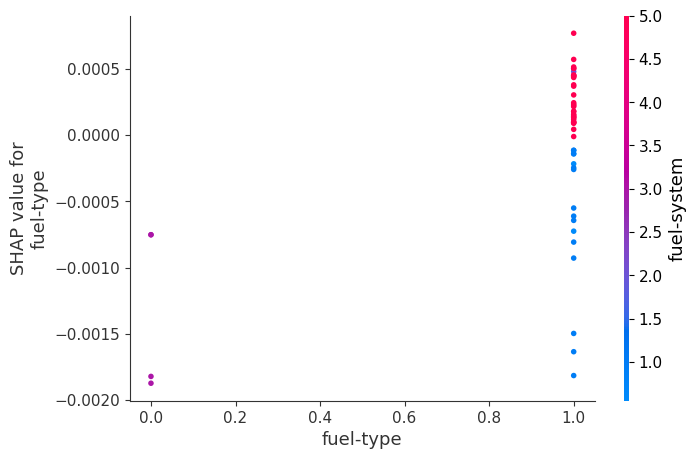

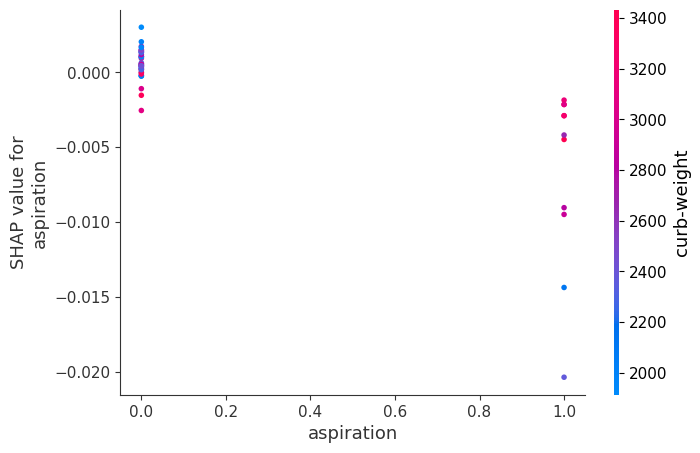

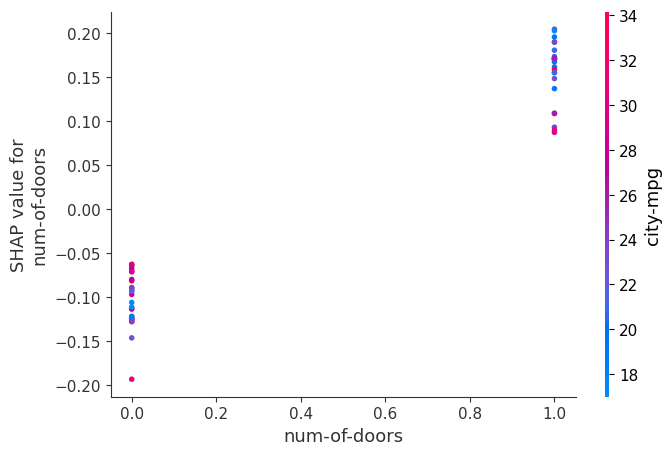

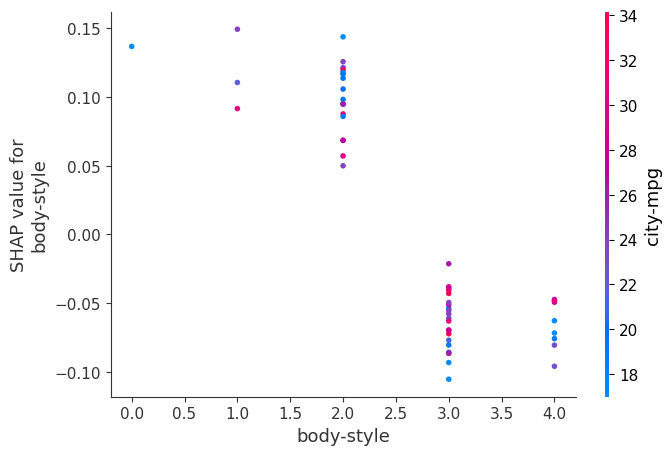

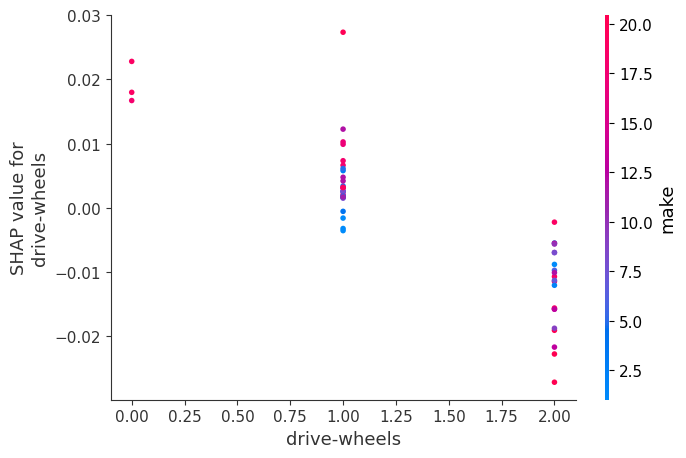

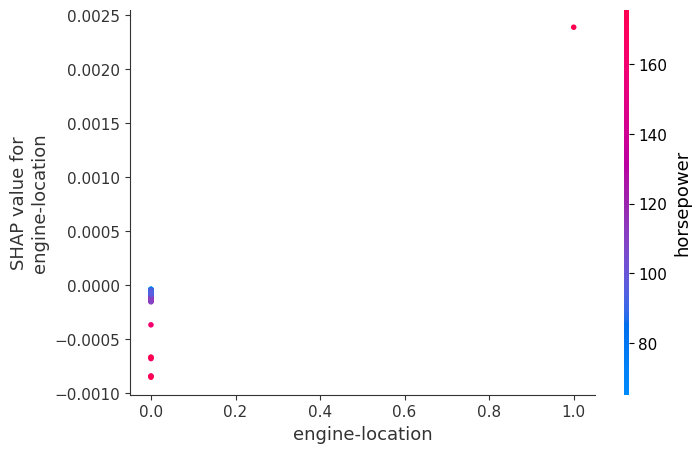

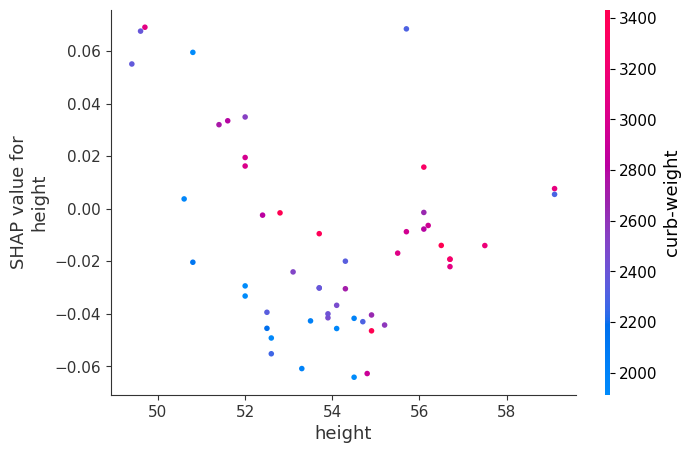

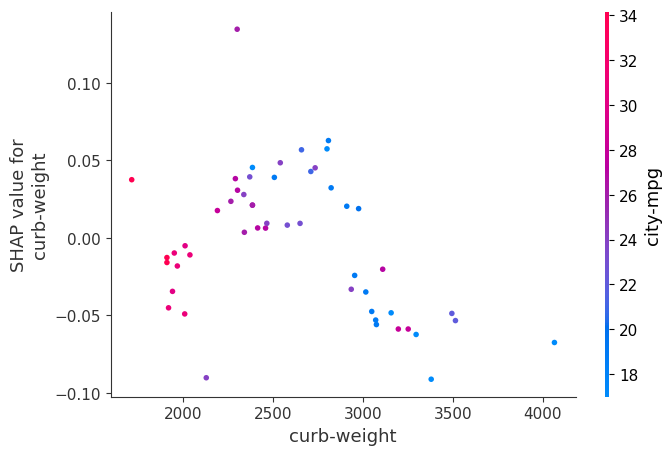

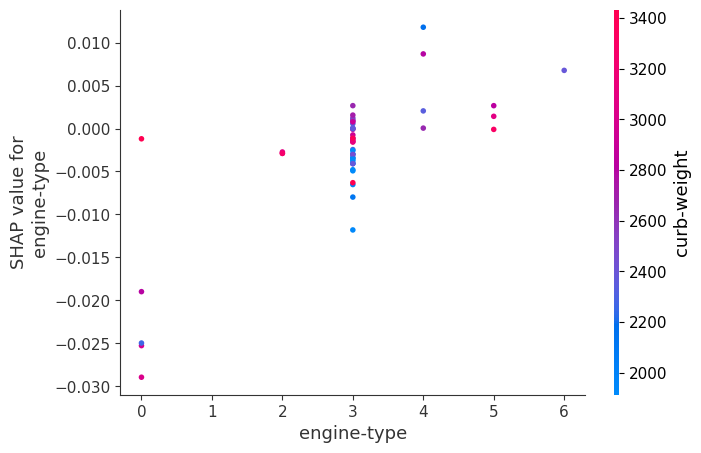

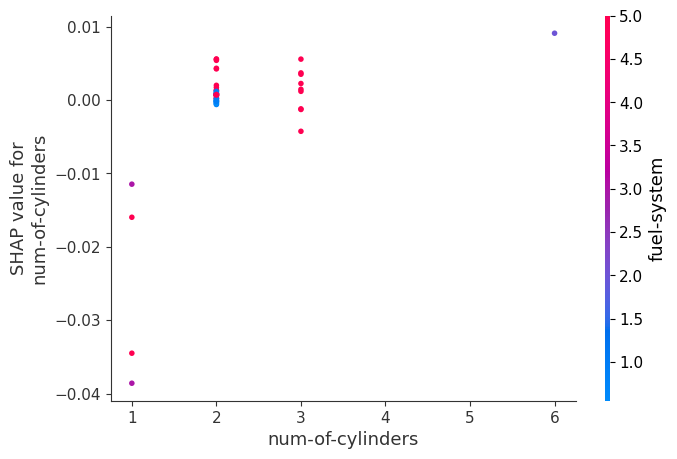

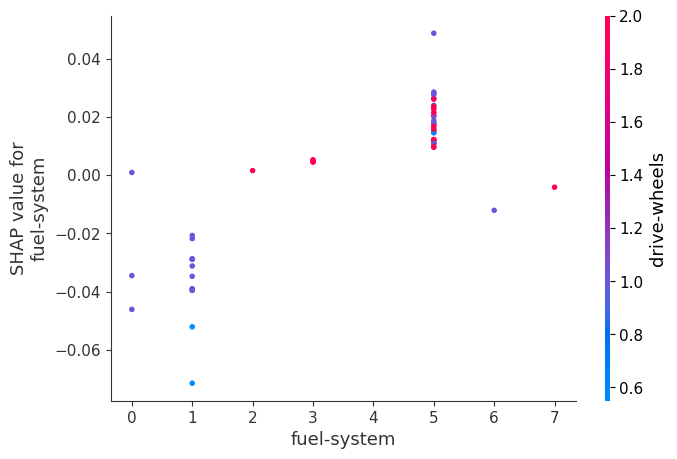

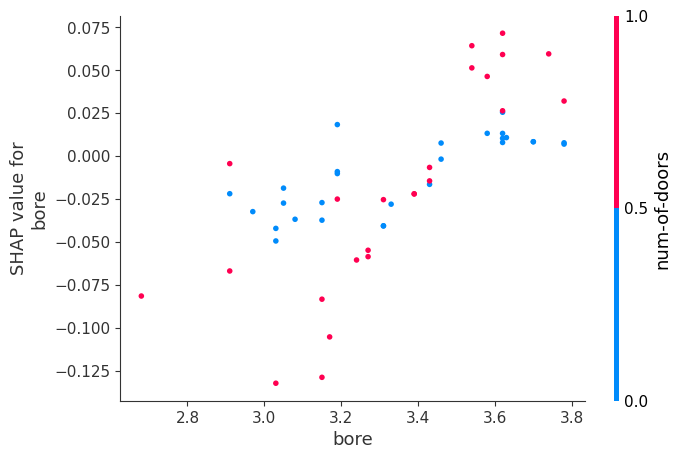

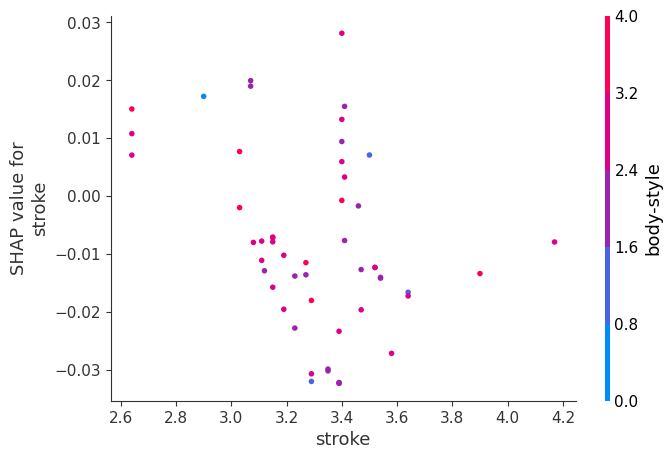

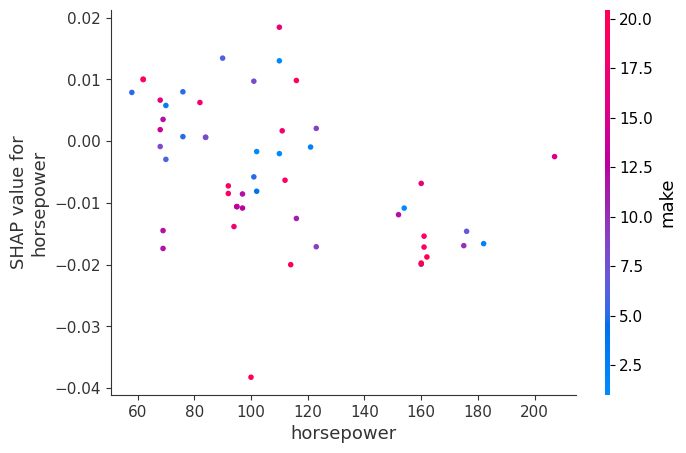

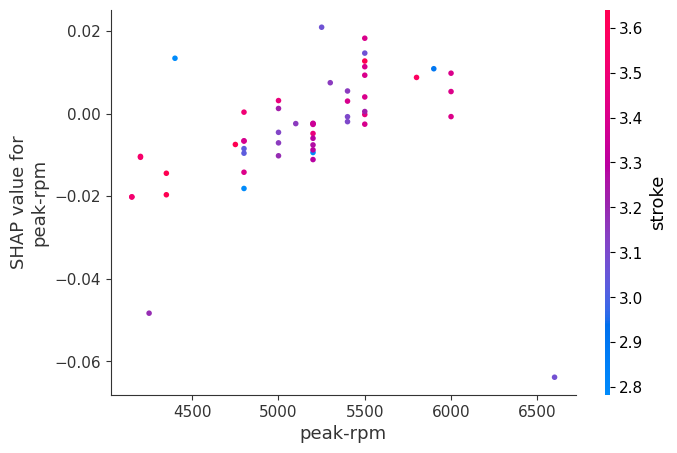

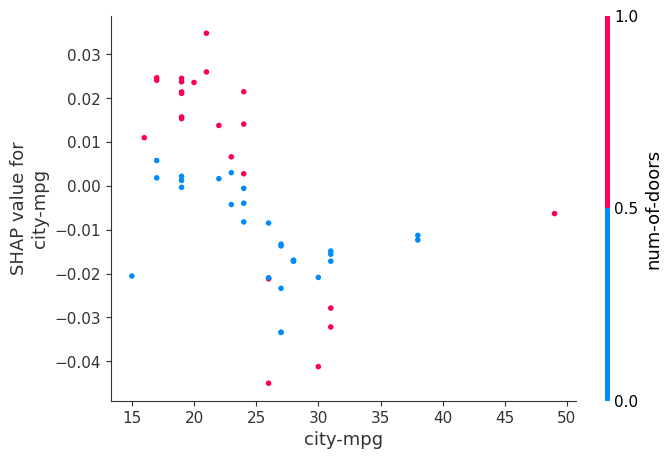

In [37]:
for feature in X_test.columns:
    shap.dependence_plot(feature, shap_values_tree[0], X_test.values, feature_names=X_test.columns)

In [ ]:
shap.multioutput_decision_plot(explainer_tree.expected_value[0], shap_values_tree[0], X_test.iloc[0,:])

ValueError: ignored

In [ ]:
print(len(X_test))
print(len(shap_values_tree[0]))

In [ ]:
for name in X_test.columns:
    shap.dependence_plot(name, shap_values_tree[0], X_test)

In [ ]:
shap.initjs()
shap.force_plot(explainer_tree.expected_value[0], shap_values_tree[0])